# Disease Classification Embedding Bag

## Table of Contents
* [Data Exploration and Cleaning](#data)
    * [Data Exploration](#data-explore)
    * [Finding Most Common Words](#common-words)
* [PyTorch Embedding Bag](#pytorch)
    * [**Dataset Class**](#most-important)
    * [Tokenizer](#tokenizer)
    * [Batching](#batches)
    * [Defining](#defining)
    * [Training](#training)
    * [Testing](#testing)
    * [Results](#results)

In [33]:
# general imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns

# Data Exploration and Cleaning <a class="anchor" id="data"></a>
Loading in our dataset and taking a look at a few rows.

In [2]:
ds = pd.read_csv('Symptom2Disease.csv')
ds = ds.drop('Unnamed: 0', axis=1)
ds.head()

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


## Data Exploration <a class="anchor" id="data-explore"></a>

0       i have been experiencing a skin rash on my arm...
1       my skin has been peeling, especially on my kne...
2       i have been experiencing joint pain in my fing...
3       there is a silver like dusting on my skin, esp...
4       my nails have small dents or pits in them, and...
                              ...                        
1195    i'm shaking and trembling all over. i've lost ...
1196    particularly in the crevices of my skin, i hav...
1197    i regularly experience these intense urges and...
1198    i have trouble breathing, especially outside. ...
1199    i constantly sneeze and have a dry cough. my i...
Name: text, Length: 1200, dtype: object
There are 24 different disease classes


<Axes: xlabel='count', ylabel='label'>

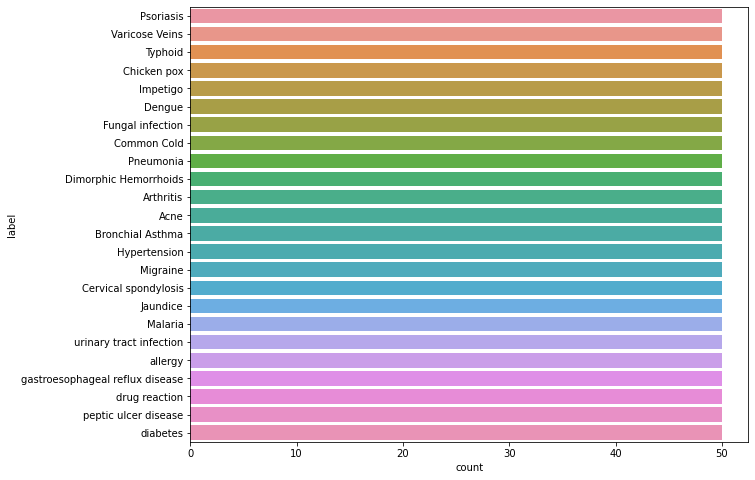

In [70]:
# changing label to integers
y_map = {k: v for v, k in enumerate(list(ds['label'].unique()))}
ds['y_map'] = ds['label'].apply(lambda x: y_map[x])

# converting text to lowercase
ds['text'] = ds['text'].apply(lambda x: x.lower())

# finding the number of unique diseases in the dataset
num_class = len(ds['label'].unique())
print('There are %s different disease classes' %num_class)
# plotting the number of every disease.
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(data=ds, y=ds['label'], orient='h')

There are 24 different disease classes and 50 observations of each disease.

## Let's find the most common words associated with each disease. <a class="anchor" id="common-words"></a>
To understand the text a little better, let's take a look at the most common words associated with each disease.

Note: I think that I may have been too focused on the sequential nature of words, seeing as the text's main purpose is to list symptoms, there could be a different way to represent the data. (Although this may be what the neural network is doign anyways).

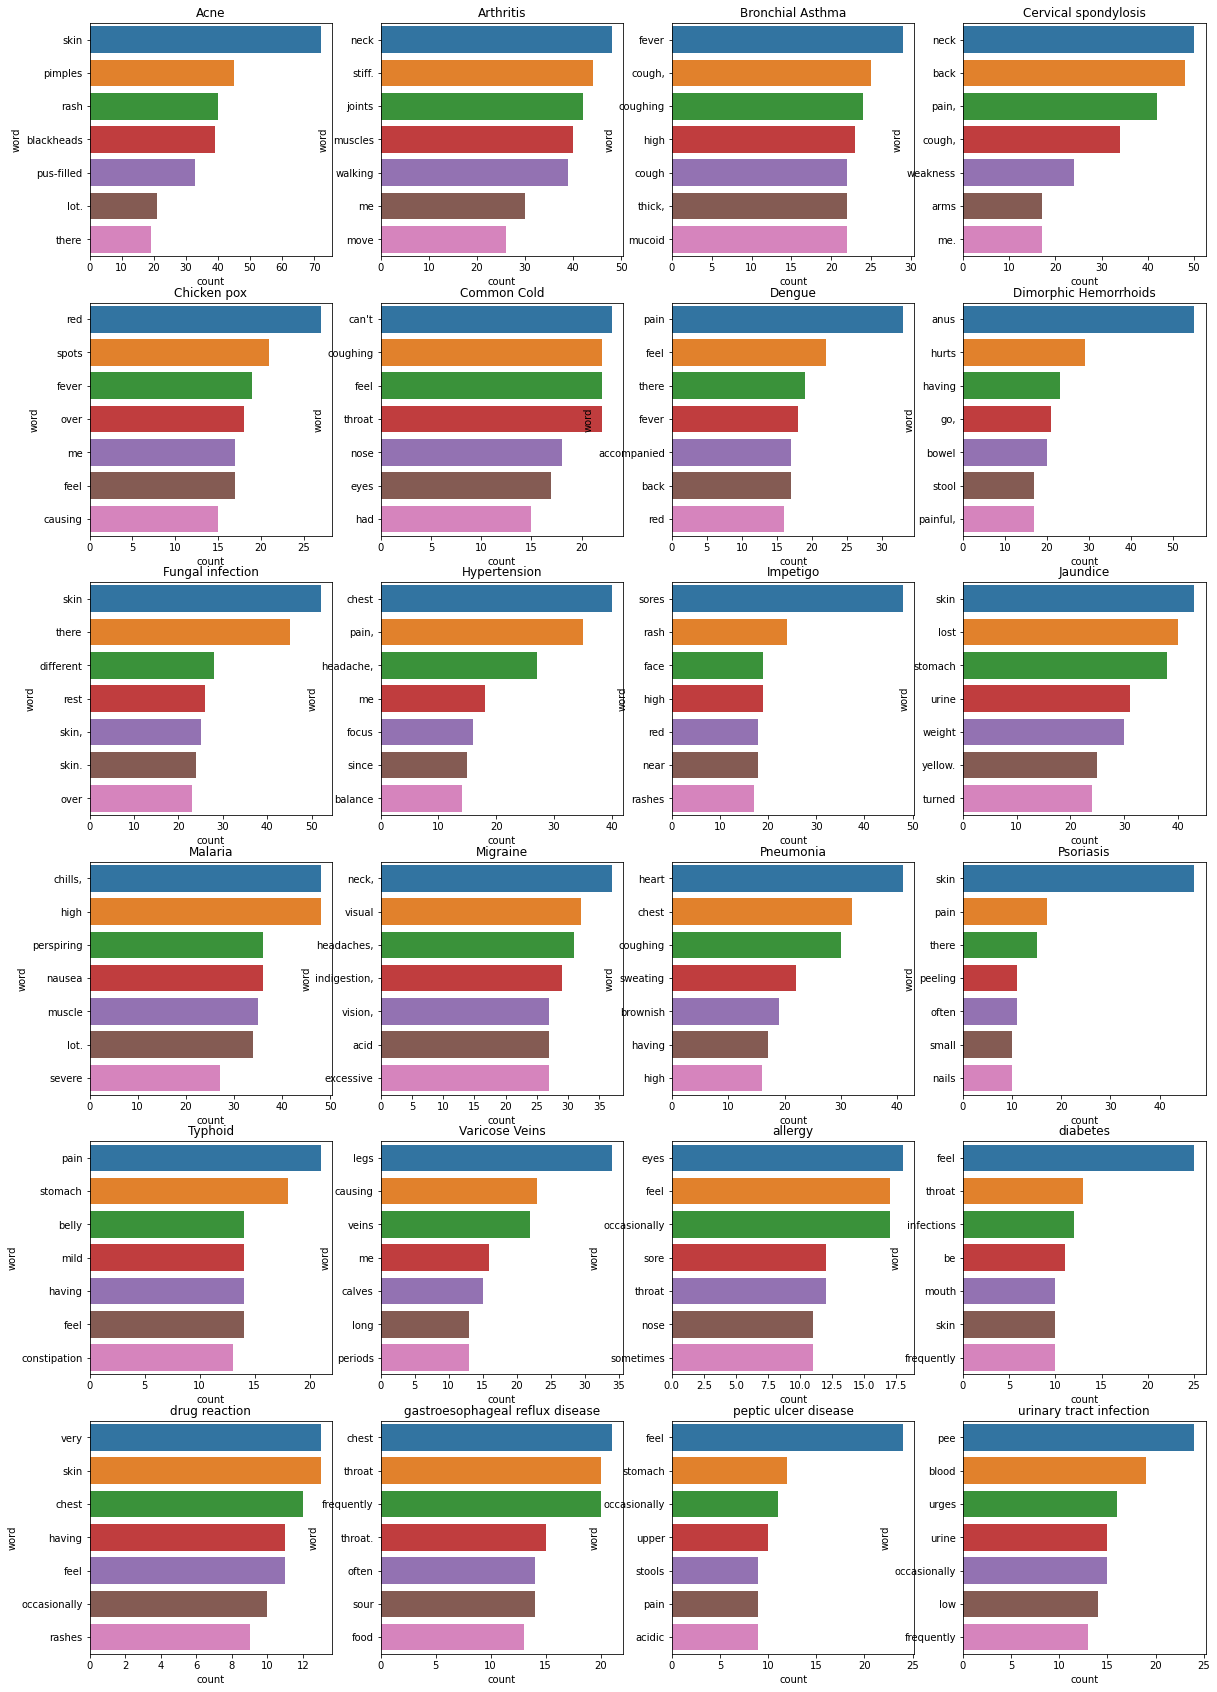

In [143]:
from collections import Counter

# some words i feel like should be ignored because they are pretty common words that aren't valuable to diagnosis.
ignore = ['a', 'been', 'has', 'my', 'i', 'been', 'to', 'have', 'really', "i'm", 'with', 'on', 'all', 'are',
         'am', 'of', "i've", 'lot', 'feeling', 'is', 'some', 'when' ,'quite', 'that', 'for', 'up' ,"it's", 'in' ,
         'the' , 'get', 'at', 'it', 'also', 'experiencing', 'experienced', 'go', 'and', 'or', 'as', 'after']

# set (sub)plot dimensions
rows, cols = 6, 4
plt.figure(figsize=(20, 30))
fig.subplots_adjust(hspace=10)

# for each disease,
n = 0
for disease in ds.groupby('label'):
    # group all the text together
    cat_text = disease[1]['text'].str.cat(sep=' ')
    # find the count of every word 
    counts = Counter(cat_text.split())
    for word in ignore:
        if word in counts:
            del counts[word]
            
    ax = plt.subplot(6, 4, n + 1)
    plt.title(disease[0])
    n += 1
    
    # take the 7 most common words and plot them
    top_7 = counts.most_common(7)
    df = pd.DataFrame(top_7, columns=['word', 'count'])
    sns.barplot(df, x=df['count'], y=df['word'], orient='h')
    

## Train-Test Split
Finally, let's split our data into a training, validation, and test set.

In [256]:
from sklearn.model_selection import train_test_split

# Splitting our dataset into train and test sets, stratifying by label.
X_train, X_test, y_train, y_test = train_test_split(
                                        ds[['text']], ds['y_map'], 
                                        test_size=0.33, random_state=42,
                                        stratify=ds['label']) 

X_train, X_valid, y_train, y_valid = train_test_split(
                                        ds[['text']], ds['y_map'], 
                                        test_size=0.1, random_state=42,
                                        stratify=ds['label']) 

## Let's Start with PyTorch <a class="anchor" id="pytorch"></a>

In [144]:
import torch
import torchtext

### Below is probably the most important thing I learned. <a class="anchor" id="most-important"></a>
Before I started this project I honestly didn't know how to feed non-tutorial data into dataloaders (pandas df, etc)  
Now I know I just need a Dataset class that has a `get item` and a `len` function!

In [258]:
from torch.utils.data import Dataset, DataLoader

class DSet(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __getitem__(self, index):
        row = self.dataframe.iloc[index].to_numpy()
        features = row[0]
        label = row[1]
        return features, label

    def __len__(self):
        return len(self.dataframe)

## Tokenizer <a class="anchor" id="tokenizer"></a>
### Why do we tokenize our input?
**Tokenization** breaks up unstructured data (strings) into structured data (characters, strings, **tokens**), which is useful because our neural networks only accept structured (numerical) data. There are many ways to tokenize your data and here I just loaded up the pretrained 'basic_english' tokenizer from the torchtext library, you can also build your own vocabulary but there are already hundreds of pretrained tokenizers that will probably be much more useful to you!  

At this point, we only have our tokens, but our neural networks only accept numerical inputs. This is where the **encoder** comes in, after we created our tokenizer, we build our vocabulary from the tokenizer and replace every token with its numerical equivalent. 

In [259]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# split data into train, validation, and test sets
train_data = DSet(pd.concat([X_train, y_train], axis=1))
valid_data = DSet(pd.concat([X_valid, y_valid], axis=1))
test_data = DSet(pd.concat([X_test, y_test], axis=1))

# basic tokenizer
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text, label in data_iter:
        yield tokenizer(text)

# we build our vocabulary with the function above and set "<unk>" as the unknown token.
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [260]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

## Batches <a class="anchor" id="batches"></a>
The `colate_batch()` function works on a batch of samples generated from the `Dataloader`, processing them according to our data processing pipelines we declared above.  
In this example, we return our text as a single tensor as input to our `EmbeddingBag` layer, the offset as a tensor of delimiters to represent the beginning sequence in the text tensor, and our label as the corresponding labels.

In [261]:
from torch.utils.data import DataLoader
device = torch.device("cpu")

# we create our batches here
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list.to(device), label_list.to(device), offsets.to(device)

train_dataloader = DataLoader(train_data, batch_size=10, shuffle=False, collate_fn=collate_batch)

## Defining the Model <a class="anchor" id="defining"></a>
This model is very simple, it consists of an [embedding bag](https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html#torch.nn.EmbeddingBag) layer and a linear layer for classification.  
The embedding bag layer is quite convenient because it doesn't require any padding (due to the text length being saved in offsets) and is suitable for this task because of the relatively short length of the inputs (meaning that the importance of the sequential data isn't as important).

In [262]:
from torch import nn

# our model, consisting of an embedding layer, a linear layer, and an output layer.
class DiseaseClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(DiseaseClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

## Training and Evaluation <a class="anchor" id="training"></a>
### Training
After defining our model, we need to train it. This isn't a tutorial and it's for me so I'll keep it brief:  
* Initialize Gradient
* Predict 
* Calculate loss
* Optimizer

### Evalulation
Calculate accuracy on the validation set.

In [263]:
num_class = len(ds['label'].unique())
vocab_size = len(vocab)
emsize = 64
model = DiseaseClassificationModel(vocab_size, emsize, num_class).to(device)

In [264]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    
    for idx, (text, label, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
            
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    
    with torch.no_grad():
        for idx, (text, label, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [265]:
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 8 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time:  0.14s | valid accuracy    0.383 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.11s | valid accuracy    0.492 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.11s | valid accuracy    0.650 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  0.11s | valid accuracy    0.758 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  0.11s | valid accuracy    0.808 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  0.11s |

## Testing <a class="anchor" id="testing"></a>
Finally, we test our model.

In [266]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.970


And you can write your own sentence to classify something yourself!

In [268]:
y_swap = {v: k for k, v in y_map.items()}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

ex_text_str = 'I have blood in my pee'


model = model.to("cpu")

print("You have %s" %y_swap[predict(ex_text_str, text_pipeline)])

You have urinary tract infection


## Results  <a class="anchor" id="results"></a>
The dataset is fairly small and the model is extremely simple, but it managed to get a test accuracy of **97%**, which I think is pretty good!